In [166]:
from __future__ import print_function

In [167]:
import tensorflow as tf
import numpy as np

In [168]:
import retro

In [169]:
from skimage import transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from collections import deque
import random
import warnings
warnings.filterwarnings('ignore')

In [170]:
env = retro.make(game='SpaceInvaders-Atari2600')

In [171]:
print("The size of our frame is: ", env.observation_space)
print("The action size is: ", env.action_space.n)
# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n, dtype=int).tolist())
possible_actions


The size of our frame is:  Box(210, 160, 3)
The action size is:  8


array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])

In [172]:
# Preprocess frame
# Take a fraem
# Garyscale it
# Resize it

def preprocess_frame(frame):
    gray = rgb2gray(frame)
    # Crop the screen (remove the part below the player)
    # Up: Down, Left: right
    cropped_frame = gray[8:-12, 4:-12]
    
    normalized_frame = cropped_frame/255.0
    
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110 X 84 * 1 frame

In [173]:
"""""
Stack frames

Stacking frames give have a sense of motion to our NN
But, we don't stack each frames, we skip 4 frames at each timestep. This means that only every fourth frame is considered. 
And then, we use this frame to form the stack_frame
The frame skipping method is already implemented in the library:
* First we preprocess frame
* Then we append the frame to the deque that automatically removes the oldest frame
* Finally we build the stacked state

This is how work stack:
* For the first frame, we feed 4 frames
* At each timestep, we add the new frame to deque and then we stack them to form a new stacked frame
* And so on
* If we're done, we create a new stack with 4 new frames because we are in a new episode
"""""

stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

print("stack size: ", len(stacked_frames))
#print(stacked_frames[0])
print("frame shape: ", stacked_frames[0].shape)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
        # Build the stacked state (first dimenstion specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2)
        
    return stacked_state, stacked_frames


stack size:  4
frame shape:  (110, 84)


In [174]:
# ### MODEL HYPERPARAMETERS
state_size = [110, 84, 4] # Our input is a stack of 4 frames 110 * 84 * 4 (width, heifht, channel)
action_size = env.action_space.n # 8 possible actions
learning_rate = 0.00025



In [175]:
import DDDQNNet 

# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DDDQNNet.DDDQNNetwork(state_size, action_size, learning_rate, name="DQNetwork")
tf = DQNetwork.build()


In [176]:
# # Reset the graph
# tf.reset_default_graph()
# # Instantiate the DQNetwork
# DQNetwork = DQNetwork(state_size, action_size, learning_rate)

In [177]:
# Saver will help us to save our model
saver = tf.train.Saver()

In [178]:
from IPython import display
import numpy as np
import time

import PIL.Image
import io

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.BytesIO()
    ima = PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()

In [179]:
#DEBUG_PRINT = True
DEBUG_PRINT = False
def print_var(var_name, var_value, debug=False):
    """
    test = 123
    print_var("test", test)    
    """
    if DEBUG_PRINT:
        print(var_name, ": ", var_value)

****************************************************
EPISODE  0


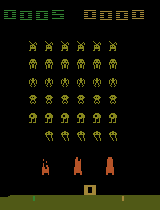

Score 5.0


In [180]:
with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
#    saver.restore(sess, "./models/model.ckpt")
    saver.restore(sess, "./play_model/model.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        imagehandle = display.display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')
        
        play_step = 0
        while True:
#        while play_step < 10:      
            ## EPSILON GREEDY STRATEGY
            # Choose action a from state s using epsilon greedy
            ## First we randomize a number
            exp_exp_tradeoff = np.random.rand()
            explore_probability = 0.01
            
            if (explore_probability > exp_exp_tradeoff):
                # Make a random action (exploration)
                action = random.choice(possible_actions)
            else:
                # Get action from Q-network (Exploitation)
                # Estimate the Qs values state
                
                # Reshape the state
                state = state.reshape((1, *state_size))
                Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
                # Take the biggerest Q values (= the best action)
                choice = np.argmax(Qs)
                action = possible_actions[choice]
    
            
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
#            print_var("next_state", next_state)                            
            print_var("reward", reward)                            
            print_var("done", done)                                        
#            env.render()
            #show_state(env, step = play_step)
            display.update_display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            play_step += 1
            
    env.close()